## 비트코인 가격을 LSTM으로 예측

In [2]:
!wget https://media.githubusercontent.com/media/mbernico/deep_learning_quick_reference/master/chapter_9/data/bitcoin.csv \
  -O bitcoin.csv

--2019-07-30 13:49:04--  https://media.githubusercontent.com/media/mbernico/deep_learning_quick_reference/master/chapter_9/data/bitcoin.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112373984 (107M) [text/plain]
Saving to: ‘bitcoin.csv’

bitcoin.csv         100%[===================>] 107.17M   221MB/s    in 0.5s    

2019-07-30 13:49:07 (221 MB/s) - ‘bitcoin.csv’ saved [112373984/112373984]



In [0]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Sequential, Input, LSTM, Dense
from keras.models import Model
import numpy as np
import os

In [0]:

from keras.callbacks import TensorBoard

def select_dates(df, start, end):
    mask = (df.index > start) & (df.index <= end)
    return df[mask]


def scale_data(df, scaler=None):
    scaled_df = pd.DataFrame(index=df.index)
    if not scaler:
        scaler = MinMaxScaler(feature_range=(-1,1))
    scaled_df["Price"] = scaler.fit_transform(df.Close.values.reshape(-1,1))
    return scaler, scaled_df


def diff_data(df):
    df_diffed = df.diff()
    df_diffed.fillna(0, inplace=True)
    return df_diffed


def lag_dataframe(data, lags=1):
    """
    creates shifted lag columns for a dataframe
    e.g. for a df with col1, it creates n lagged versions of col1

    """
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(lags, 0, -1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)

    cols = df.columns.tolist()
    for i, col in enumerate(cols):
        if i == 0:
            cols[i] = "x"
        else:
            cols[i] = "x-" + str(i)

    cols[-1] = "y"
    df.columns = cols
    return df


def prep_data(df_train, df_test, lags):
#     df_train = diff_data(df_train)
    scaler, df_train = scale_data(df_train)
#     df_test = diff_data(df_test)
    scaler, df_test = scale_data(df_test, scaler)
    df_train = lag_dataframe(df_train, lags=lags)
    df_test = lag_dataframe(df_test, lags=lags)

    X_train = df_train.drop("y", axis=1)
    y_train = df_train.y
    X_test = df_test.drop("y", axis=1)
    y_test = df_test.y

    X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, X_test, y_train, y_test


# def build_network(sequence_length=10, batch_shape=100, input_dim=1):
#     inputs = Input(batch_shape=(batch_shape, sequence_length, input_dim), name="input")
#     lstm1 = LSTM(100, activation='tanh', return_sequences=True, stateful=True, name='lstm1')(inputs)
#     lstm2 = LSTM(100, activation='tanh', return_sequences=False, stateful=True, name='lstm2')(lstm1)
#     output = Dense(1, activation='tanh', name='output')(lstm2)
#     model = Model(inputs=inputs, outputs=output)
#     model.compile(optimizer='adam', loss='mse')
#     return model


# def create_callbacks(name):
#     tensorboard_callback = TensorBoard(log_dir=os.path.join(os.getcwd(), "tb_log", name), write_graph=True, write_grads=False)

#     return [tensorboard_callback]


# def make_prediction(X_test, model):
#     y_hat = model.predict(X_test)
#     y_hat = np.reshape(y_hat, (y_hat.size,))
#     return y_hat

In [0]:
# def main():
LAGS=10
df = pd.read_csv("bitcoin.csv", index_col=False)

In [75]:
df[:3].T

,0,1,2
Timestamp,1.417412e+09,1.417412e+09,1.417412e+09
Open,3.000000e+02,3.000000e+02,3.000000e+02
High,3.000000e+02,3.000000e+02,3.000000e+02
Low,3.000000e+02,3.000000e+02,3.000000e+02
Close,3.000000e+02,3.000000e+02,3.000000e+02
Volume_(BTC),1.000000e-02,1.000000e-02,1.000000e-02
Volume_(Currency),3.000000e+00,3.000000e+00,3.000000e+00
Weighted_Price,3.000000e+02,3.000000e+02,3.000000e+02


In [0]:
df["Time"] = pd.to_datetime(df["Timestamp"], unit='s')
df.index = df["Time"]
df = df.drop(["Time", "Timestamp"], axis=1)
df_train = select_dates(df, start="2017-01-01", end="2017-05-31")
df_test = select_dates(df, start="2017-06-01", end="2017-06-30")

In [0]:
X_train, X_test, y_train, y_test = prep_data(df_train, df_test, lags=LAGS)
# model = build_network(sequence_length=LAGS)
# callbacks = create_callbacks("lstm_100_100")
# model.fit(x=X_train, y=y_train,
#           batch_size=100,
#           epochs=10,
#           callbacks=callbacks)
# model.save("lstm_model.h5")


# if __name__ == "__main__":
#     main()

In [0]:
sequence_length, batch_shape, input_dim =10, 100, 1
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, stateful=True,
               batch_size=batch_shape,
               input_shape=(sequence_length, input_dim)))
model.add(LSTM(100, activation='tanh', return_sequences=False, stateful=True))
model.add(Dense(1, activation='tanh', name='output'))
model.compile(optimizer='adam', loss='mse')

In [88]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=3)

Epoch 1/3
216000/216000 [==============================] - 60s 276us/step - loss: 2.5838e-04
Epoch 2/3
216000/216000 [==============================] - 58s 268us/step - loss: 1.9931e-05
Epoch 3/3
216000/216000 [==============================] - 58s 268us/step - loss: 1.6874e-05


In [0]:
# from keras.models import load_model
# model_1 = load_model("lstm_model.h5")

In [0]:
X_tmp = X_test[:10000]

In [0]:
y_hat = model.predict(X_tmp, batch_size=100)

In [91]:
y_hat = np.reshape(y_hat, (y_hat.size,))
y_hat

array([ 0.00119096, -0.10078523, -0.21766464, ...,  0.2780965 ,
        0.27169418,  0.2649903 ], dtype=float32)

In [0]:
y_tmp = y_test[:10000]

In [61]:
# list(zip(y_hat, y_tmp))[:100]

[(0.11622844, 0.11538461538461542),
 (0.1005057, 0.14439560439560803),
 (0.0886499, 0.11032967032966996),
 (0.09271534, 0.21450549450548934),
 (0.08481257, 0.12373626373626617),
 (0.09635347, 0.15912087912087436),
 (0.10231594, 0.1151648351648404),
 (0.11107366, 0.1151648351648304),
 (0.11485185, 0.07538461538462181),
 (0.119803876, 0.003296703296705325),
 (0.1301936, 0.14175824175823779),
 (0.113398276, 0.15978021978021942),
 (0.09798144, 0.16439560439560483),
 (0.09239622, 0.14857142857142341),
 (0.096358664, 0.19098901098901222),
 (0.09594067, 0.17010989010989536),
 (0.09981365, 0.10681318681318965),
 (0.11206661, 0.11076923076923001),
 (0.11756329, 0.10813186813185977),
 (0.11748675, 0.15648351648352413),
 (0.10873132, 0.11164835164835009),
 (0.10935, 0.10615384615384459),
 (0.11132922, 0.12461538461538625),
 (0.108955316, 0.1151648351648304),
 (0.1088039, 0.11010989010989494),
 (0.10980082, 0.06483516483516086),
 (0.11644201, 0.09736263736264379),
 (0.114749976, 0.1292307692307616

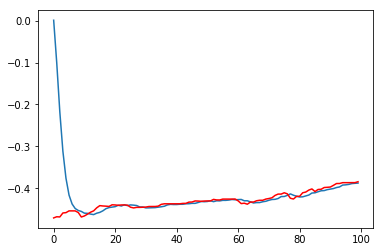

In [93]:
import matplotlib.pyplot as plt
plt.plot(y_hat[:100])
plt.plot(y_tmp.values[:100], c='r')

In [94]:
(((y_hat - y_tmp)**2).mean())**0.5

0.01274458577478987

## 케라스 메트릭

Epoch 1/500
 - 1s - loss: 0.8051 - mean_squared_error: 0.8051 - mean_absolute_error: 0.7953 - mean_absolute_percentage_error: 144.6077 - cosine_proximity: 1.0000
Epoch 2/500
 - 0s - loss: 0.7977 - mean_squared_error: 0.7977 - mean_absolute_error: 0.7911 - mean_absolute_percentage_error: 143.5369 - cosine_proximity: 1.0000
Epoch 3/500
 - 0s - loss: 0.7904 - mean_squared_error: 0.7904 - mean_absolute_error: 0.7869 - mean_absolute_percentage_error: 142.4663 - cosine_proximity: 1.0000
Epoch 4/500
 - 0s - loss: 0.7831 - mean_squared_error: 0.7831 - mean_absolute_error: 0.7827 - mean_absolute_percentage_error: 141.3959 - cosine_proximity: 1.0000
Epoch 5/500
 - 0s - loss: 0.7759 - mean_squared_error: 0.7759 - mean_absolute_error: 0.7784 - mean_absolute_percentage_error: 140.3258 - cosine_proximity: 1.0000
Epoch 6/500
 - 0s - loss: 0.7687 - mean_squared_error: 0.7687 - mean_absolute_error: 0.7742 - mean_absolute_percentage_error: 139.2563 - cosine_proximity: 1.0000
Epoch 7/500
 - 0s - loss: 0.

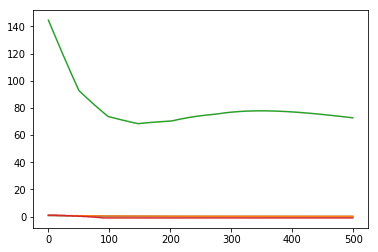

In [66]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
# prepare sequence
X = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# create model
model = Sequential()
model.add(Dense(2, input_dim=1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape', 'cosine'])
# train model
history = model.fit(X, X, epochs=500, batch_size=len(X), verbose=2)
# plot metrics
pyplot.plot(history.history['mean_squared_error'])
pyplot.plot(history.history['mean_absolute_error'])
pyplot.plot(history.history['mean_absolute_percentage_error'])
pyplot.plot(history.history['cosine_proximity'])
pyplot.show()